# Notebook to reproduce figure 5 and supplementary figures

## import

In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import ScalarFormatter, NullFormatter
from matplotlib import gridspec
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr

## functions

In [26]:
def scatter_plot_clusters(x, y, labelx, labely, num_bins, clusters, adatauns, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))

    # Binning
    bins = np.linspace(min(x), max(x), num_bins + 1)
    bin_indices = np.digitize(x, bins)
    bin_means = [y[bin_indices == i].mean() for i in range(1, len(bins))]
    bin_stds = [y[bin_indices == i].std() for i in range(1, len(bins))]
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Color by cluster
    cluster_palette = sns.color_palette("coolwarm", len(clusters.unique()))
    cluster_color_dict = dict(zip(sorted(clusters.unique()), cluster_palette))

    # Scatter plot
    for clust in sorted(clusters.unique()):
        mask = clusters == clust
        ax.scatter(
            x[mask], y[mask],
            alpha=0.8,
            label=f"{clust}",
            color=cluster_color_dict[clust],
            edgecolor='black',
            linewidths=0.05,
            s=40
        )

    # Mean and std lines
    ax.plot(bin_centers, bin_means, color='black', linestyle='-', linewidth=2, alpha=0.8)
    ax.plot(bin_centers, np.array(bin_means) + np.array(bin_stds), color='black', linestyle='--', linewidth=2, alpha=0.4)
    ax.plot(bin_centers, np.array(bin_means) - np.array(bin_stds), color='black', linestyle='--', linewidth=2, alpha=0.4)

    # Labels and legend
    ax.set_xlabel(labelx, fontsize=16)
    ax.set_ylabel(labely, fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.7)
    sns.despine(ax=ax)

    legend = ax.legend(title='Clusters', loc='lower right', fontsize=14, title_fontsize=14, handlelength=1, handleheight=1.2, markerscale=1.5)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_linewidth(1)


    

In [27]:
def create_layer_df(adata,column_name):
    layers = ['outer', 'inner']
    data = [(adata[adata.obs.layer == layer].obs[column_name].values, layer) for layer in layers]
    return pd.DataFrame({
        'Value': [val for values, _ in data for val in values],
        'Layer': [layer for values, layer in data for _ in values]
    })

In [28]:
def add_significance_bar(ax, pval, x1, x2, y_max, h=3, fontsize=12):
    y = y_max + h 
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
    if pval < 0.001:
        significance = '***'
    elif pval < 0.01:
        significance = '**'
    elif pval < 0.05:
        significance = '*'
    else:
        significance = 'ns'
    ax.text((x1 + x2) / 2, y + h, significance, ha='center', fontsize=fontsize)

In [29]:
def add_normalized_id(adata, column_name):
    id_vals = adata.obs[column_name]
    range_vals = id_vals.max() - id_vals.min()
    id_norm = (id_vals - id_vals.min())/range_vals
    adata.obs[f'norm_{column_name}']=id_norm

In [30]:
def add_normalized_id_xenopus(adata1, adata2 , column_name):
    
    vals1 = adata1.obs[column_name]
    vals2 = adata2.obs[column_name]

    all_vals = np.concatenate([vals1, vals2])
    range_vals = all_vals.max() - all_vals.min()

    id_norm1 = (vals1 - all_vals.min())/range_vals
    id_norm2 = (vals2 - all_vals.min())/range_vals
    
    adata1.obs[f'norm_{column_name}']=id_norm1
    adata2.obs[f'norm_{column_name}']=id_norm2

In [54]:
def return_mean_std(adata):
    clusters = sorted(adata.obs.cluster.unique())
    means_pl = np.zeros(len(clusters))
    std_pl = np.zeros(len(clusters))
    means_ps = np.zeros(len(clusters))
    std_ps = np.zeros(len(clusters))

    for i,c in enumerate(clusters):
        means_pl[i] = np.mean(adata[adata.obs.cluster == c].obs.pluripotency)
        std_pl[i] = np.std(adata[adata.obs.cluster == c].obs.pluripotency)
        means_ps[i] = np.mean(adata[adata.obs.cluster == c].obs.dpt_pseudotime)
        std_ps[i] = np.std(adata[adata.obs.cluster == c].obs.dpt_pseudotime)

    return means_pl, std_pl, means_ps, std_ps

## Tran et al.

Import data with annotations on local ID obtained in Notebook 'Local_ID'

### FBS

In [33]:
adata_fbs = sc.read('../Datasets/FBS_to_plot.h5ad')
#adata_fbs.obs.to_csv("../Metadata/Metadata_FBS.csv")

In [34]:
adata_fbs.obs

,medium,day,replicate,cell_type,n_counts,log_counts,n_genes,mt_frac,cluster,pluripotency,naive_pluripotency,cluster_pluripotency,cluster_naive_pluripotency,dpt_pseudotime,local_ID_600
CellId,,,,,,,,,,,,,,,
cgttatcggtccccgtaa-1,FBS,3,2,MEF,49571,10.811161,7529,0.0,3,0.366978,0.263468,0.418040,0.458665,0.167735,0.622227
cgagcagaaggggaaata,FBS,3,2,MEF,45478,10.724984,7371,0.0,3,0.466088,0.344327,0.418040,0.458665,0.167583,0.703536
cgaaagggccatcataga,FBS,3,2,MEF,40095,10.599007,7053,0.0,3,0.469549,0.355049,0.418040,0.458665,0.166336,0.674021
agtaaagtacaggactcg,FBS,3,2,MEF,39911,10.594407,6205,0.0,3,0.365417,0.327380,0.418040,0.458665,0.161395,0.559329
aagccagagtgagtccta,FBS,3,2,MEF,38445,10.556984,6885,0.0,3,0.369431,0.293548,0.418040,0.458665,0.161709,0.722621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
atacttatgaagattagt,FBS,0,1,MEF,2779,7.929846,1678,0.0,1,0.338835,0.506209,0.148889,0.160110,0.105842,0.409512
atatacagacccctatta,FBS,0,1,MEF,2722,7.909122,1325,0.0,4,0.490066,0.671096,0.543279,0.662540,0.122858,0.433018
tccaagtggcagagaccc,FBS,0,1,MEF,2629,7.874359,1488,0.0,4,0.330285,0.519715,0.543279,0.662540,0.097810,0.549080


In [36]:
add_normalized_id(adata_fbs, 'local_ID_600')

Plot UMAP of local ID and pluripotency

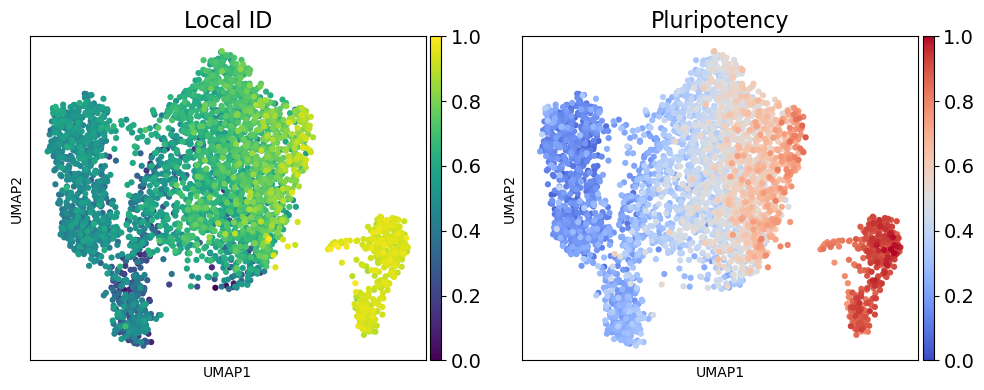

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# UMAP plot for 'local_ID_600'
sc.pl.umap(adata_fbs, color='norm_local_ID_600', title='Local ID', color_map='viridis', alpha=1., show=False, size=80, ax=axes[0])
axes[0].set_title('Local ID', fontsize=16)  # Set the title font size to 16

# UMAP plot for 'pluripotency'
sc.pl.umap(adata_fbs, color='pluripotency', title='Pluripotency', color_map='coolwarm', alpha=1., show=False, size=80, ax=axes[1])
axes[1].set_title('Pluripotency', fontsize=16)  # Set the title font size to 16

#layout
for ax in axes:
    colorbar = ax.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=14)
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

Scatter plot in figure 5

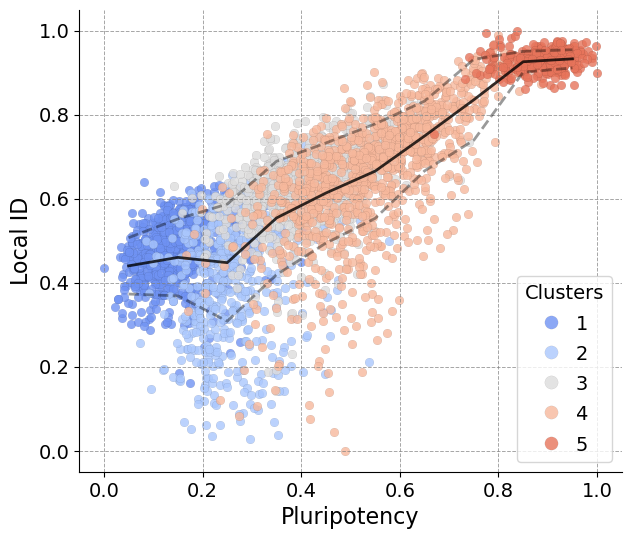

In [38]:
scatter_plot_clusters(adata_fbs.obs['pluripotency'], adata_fbs.obs['norm_local_ID_600'],  'Pluripotency', 'Local ID', 10, adata_fbs.obs['cluster'], adata_fbs.uns)

In [39]:
r = adata_fbs.obs[['pluripotency', 'norm_local_ID_600']].corr().iloc[0, 1]
print(f"Pearson r: {r:.3f}")

Pearson r: 0.795


### A2S

In [40]:
adata_a2s = sc.read('../Datasets/A2S_to_plot.h5ad')
#adata_a2s.obs.to_csv("../Metadata/Metadata_A2S.csv")

In [41]:
add_normalized_id(adata_a2s, 'local_ID_600')

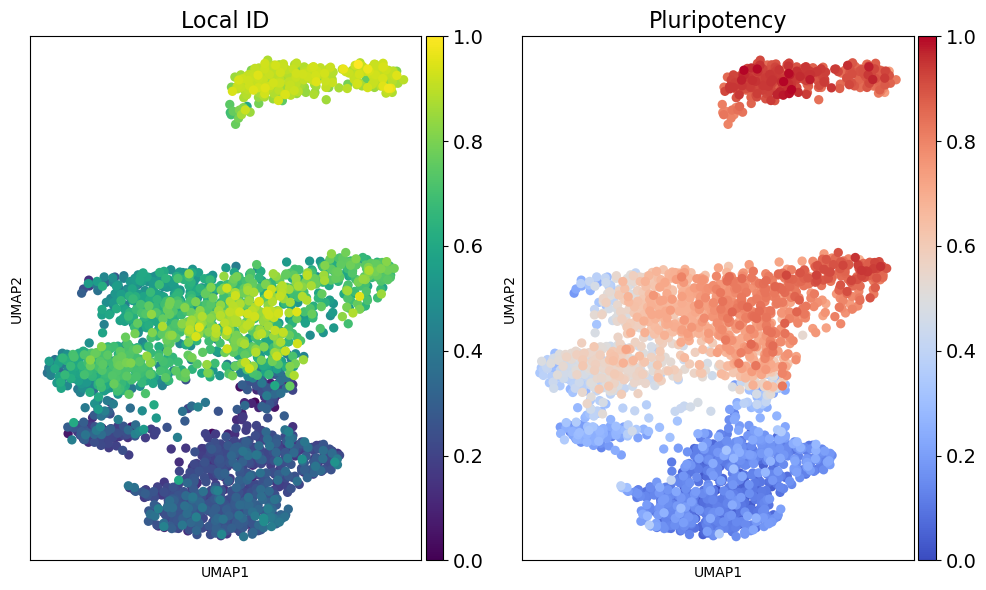

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# UMAP plot for 'local_ID_300'
sc.pl.umap(adata_a2s, color='norm_local_ID_600', title='Local ID', color_map='viridis', alpha=1., show=False, size=180, ax=axes[0])
axes[0].set_title('Local ID', fontsize=16)  # Set the title font size to 16

# UMAP plot for 'pluripotency'
sc.pl.umap(adata_a2s, color='pluripotency', title='Pluripotency', color_map='coolwarm', alpha=1., show=False, size=180, ax=axes[1])
axes[1].set_title('Pluripotency', fontsize=16)  # Set the title font size to 16

#layout
for ax in axes:
    colorbar = ax.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=14)
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

Scatter plot in figure 5

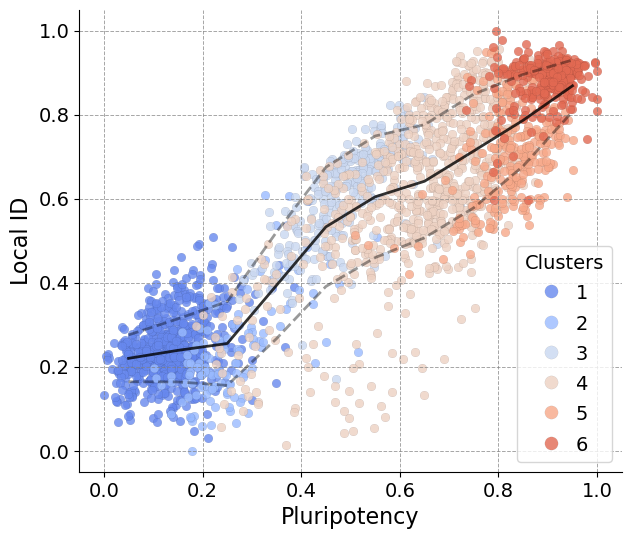

In [44]:
scatter_plot_clusters(adata_a2s.obs['pluripotency'], adata_a2s.obs['norm_local_ID_600'],  'Pluripotency', 'Local ID', 10, adata_a2s.obs['cluster'], adata_a2s.uns)

In [45]:
r = adata_a2s.obs[['pluripotency', 'norm_local_ID_600']].corr().iloc[0, 1]
print(f"Pearson r: {r:.3f}")

Pearson r: 0.898


## Xenopus

Import data with annotations on local ID obtained in Notebook 'Local_ID'

In [3]:
adata_ivf = sc.read('../Datasets/Xenopus_IVF_to_plot.h5ad')
adata_nt = sc.read('../Datasets/Xenopus_NT_to_plot.h5ad')

In [48]:
add_normalized_id_xenopus(adata_ivf, adata_nt, 'local_ID_100')

UMAP in figure 5

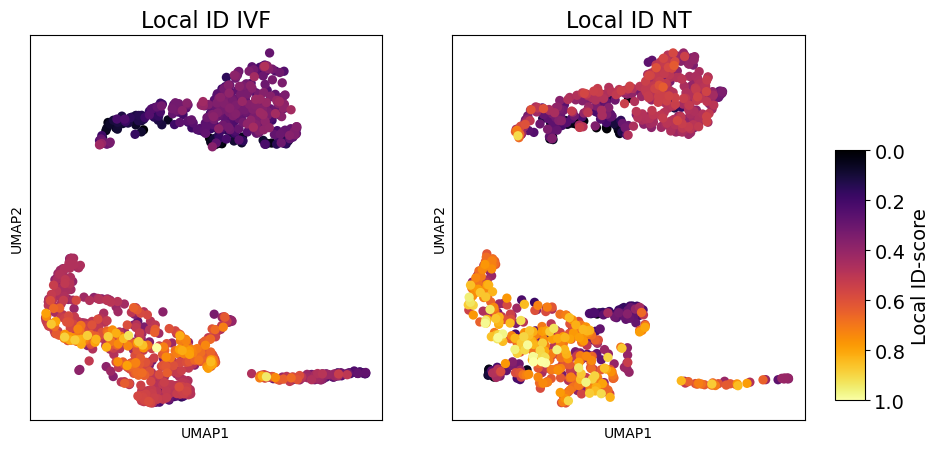

In [50]:
#plot the local ID in IVF and NT

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

n_neighbors = 100
sc.pl.umap(adata_ivf, color='norm_local_ID_100', title='Local ID IVF', color_map='inferno', alpha=1., ax=axes[0], show=False, colorbar_loc=None, size=180)
sc.pl.umap(adata_nt, color='norm_local_ID_100', title='Local ID NT', color_map='inferno', alpha=1., ax=axes[1], show=False, colorbar_loc=None, size=180)

# Titles
axes[0].set_title('Local ID IVF', fontsize=16)
axes[1].set_title('Local ID NT', fontsize=16)

# add colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.030, 0.5])  # (left, bottom, width, height)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Local ID-score', fontsize=14) 
cbar.ax.tick_params(labelsize=14)
cbar.ax.invert_yaxis()

plt.show()

In [51]:
#compare outer and inner layer

outer = ['1','2','4']
inner = ['0','3','5','6','8','9']

dict_layers = {'outer' : outer, 'inner' : inner}

# Create dictionary that maps each cluster to respective layer
cluster_to_layer = {cluster: 'outer' for cluster in dict_layers['outer']}
cluster_to_layer.update({cluster: 'inner' for cluster in dict_layers['inner']})

# map dictionary
adata_ivf.obs['layer'] = adata_ivf.obs['seurat_clusters'].astype(str).map(cluster_to_layer)
adata_nt.obs['layer'] = adata_nt.obs['seurat_clusters'].astype(str).map(cluster_to_layer)

In [52]:
#create dataframes with the local ID measurements for the two layers (in the two conditions)
df_ivf = create_layer_df(adata_ivf, 'norm_local_ID_100')
df_nt = create_layer_df(adata_nt, 'norm_local_ID_100')

#calculate significance between inner and outer layer IDs
pval_ivf = mannwhitneyu(
    df_ivf[df_ivf['Layer'] == 'inner']['Value'],
    df_ivf[df_ivf['Layer'] == 'outer']['Value']
).pvalue

pval_nt = mannwhitneyu(
    df_nt[df_nt['Layer'] == 'inner']['Value'],
    df_nt[df_nt['Layer'] == 'outer']['Value']
).pvalue

Boxplot in figure 5

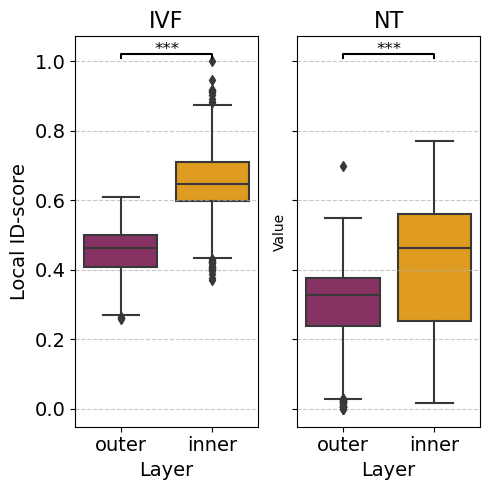

In [53]:
# boxplot
fig, axes = plt.subplots(1, 2, figsize=(5, 5), sharey=True)

colors = plt.get_cmap('inferno')

orange = 'orange'
purple = colors(0.4)

# IVF plot
sns.boxplot(x='Layer', y='Value', data=df_ivf, palette=[purple, orange], ax=axes[0])
axes[0].set_title('IVF',  fontsize=16)
axes[0].set_xlabel('Layer',  fontsize=14)
axes[0].set_ylabel('Local ID-score',  fontsize=14)
axes[0].yaxis.grid(True, linestyle="--", alpha=0.7)
add_significance_bar(axes[0], pval_ivf, 0, 1, 1, 0.01)

# NT plot
sns.boxplot(x='Layer', y='Value', data=df_nt, palette=[purple, orange], ax=axes[1])
axes[1].set_title('NT',  fontsize=16)
axes[1].set_xlabel('Layer',fontsize=14)
axes[1].yaxis.grid(True, linestyle="--", alpha=0.7)
add_significance_bar(axes[1], pval_nt, 0, 1, 1, 0.01)

axes[0].tick_params(axis='both', labelsize=14)  
axes[1].tick_params(axis='both', labelsize=14)

plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

## Supplementary figures

Reproduce supplementary figures 

In [55]:
means_pl, std_pl, means_ps, std_ps = return_mean_std(adata_fbs)

In [56]:
means_pl_A, std_pl_A, means_ps_A, std_ps_A = return_mean_std(adata_a2s)

/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_57124/3595318574.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


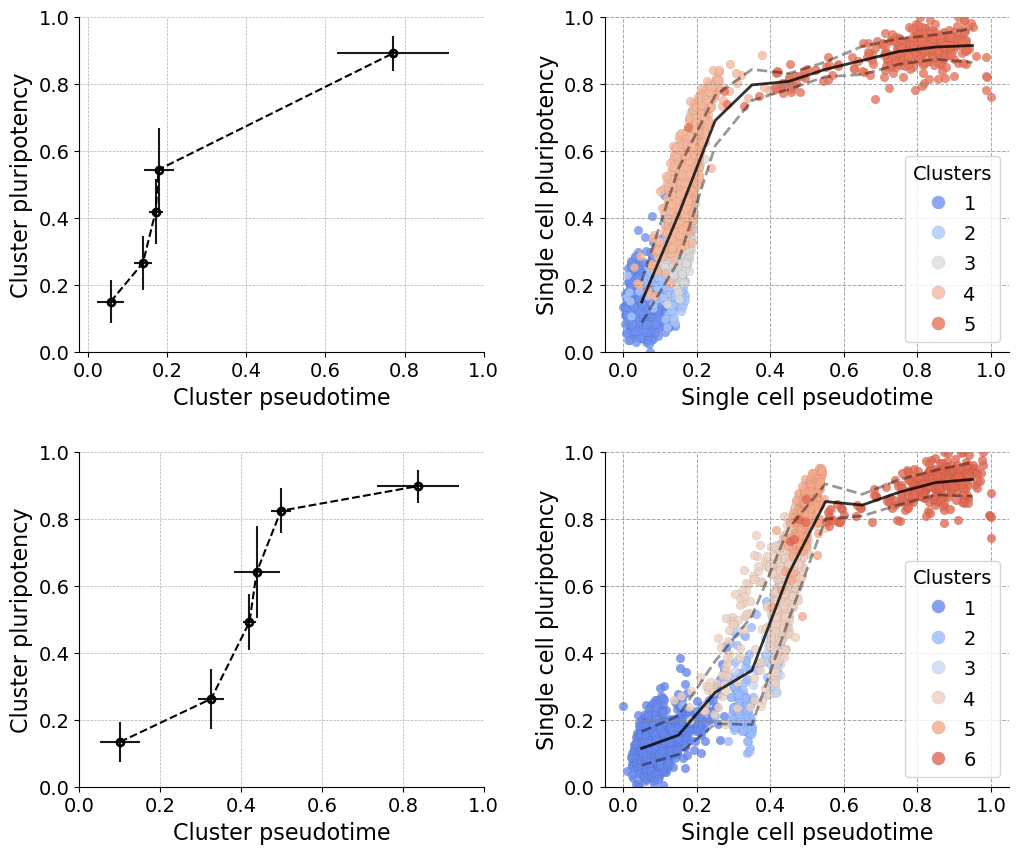

In [59]:
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1,1], height_ratios=[1, 1], wspace=0.3, hspace=0.3)
axs = np.empty((2, 2), dtype=object)
for i in range(2):
    for j in range(2):
        axs[i, j] = fig.add_subplot(gs[i, j])

# --- PLOT 1: means_ps vs means_pl ---
ax = axs[0, 0]
ax.plot(means_ps, means_pl, marker='.', markersize=10,
        markerfacecolor='none', markeredgewidth=2, color='black', linestyle='--')
ax.errorbar(means_ps, means_pl, xerr=std_ps, yerr=std_pl, fmt=' ', alpha=0.9, color='black')

ax.set_xlabel('Cluster pseudotime', fontsize=16)
ax.set_ylabel('Cluster pluripotency', fontsize=16)
ax.ticklabel_format(style='plain', useOffset=False, axis='both')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylim(0., 1.)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
sns.despine(ax=ax)

# --- PLOT 2: means_ps_A vs means_pl_A ---
ax = axs[1, 0]
ax.plot(means_ps_A, means_pl_A, marker='.', markersize=10,
        markerfacecolor='none', markeredgewidth=2, color='black', linestyle='--')
ax.errorbar(means_ps_A, means_pl_A, xerr=std_ps_A, yerr=std_pl_A, fmt=' ', alpha=0.9, color='black')

ax.set_xlabel('Cluster pseudotime', fontsize=16)
ax.set_ylabel('Cluster pluripotency', fontsize=16)
ax.ticklabel_format(style='plain', useOffset=False, axis='both')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylim(0, 1.)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
sns.despine(ax=ax)

# --- PLOT 3: scatter plot adata_fbs ---
ax = axs[0, 1]
scatter_plot_clusters(
    adata_fbs.obs.dpt_pseudotime,
    adata_fbs.obs.pluripotency,
    'Single cell pseudotime',
    'Single cell pluripotency',
    10,
    adata_fbs.obs['cluster'],
    adata_fbs.uns,
    ax=ax  # <- Pass ax for subplot
)
ax.set_ylim(0, 1.)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_rasterized(True)


# --- PLOT 4: scatter plot adata_a2s ---
ax = axs[1, 1]

scatter_plot_clusters(
    adata_a2s.obs.dpt_pseudotime,
    adata_a2s.obs.pluripotency,
    'Single cell pseudotime',
    'Single cell pluripotency',
    10,
    adata_a2s.obs['cluster'],
    adata_a2s.uns,
    ax=ax  #
)
ax.set_ylim(0, 1.)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_rasterized(True)

plt.tight_layout()
plt.show()


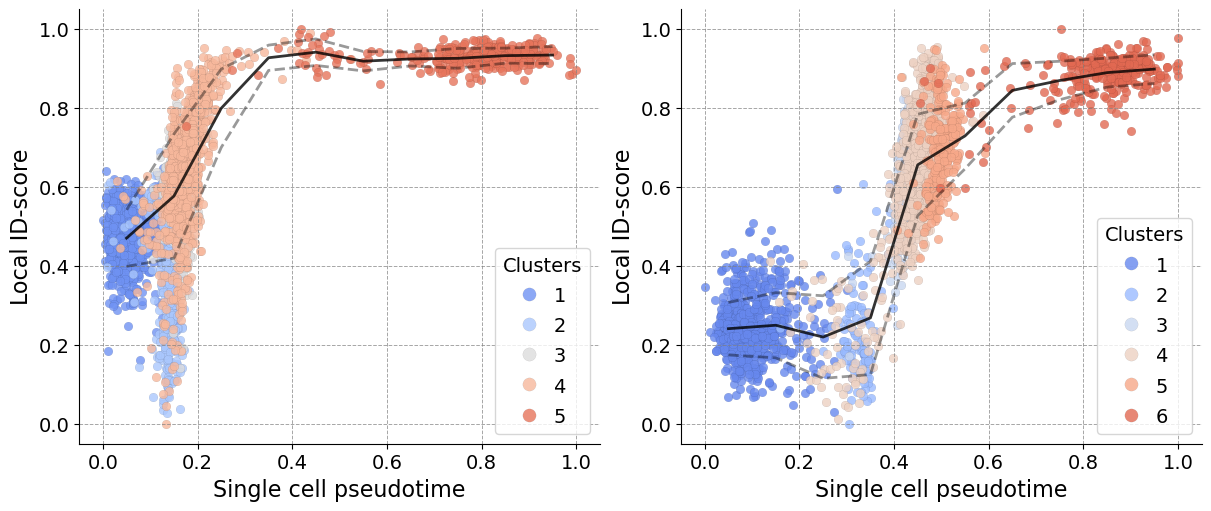

In [58]:
fig = plt.figure(figsize=(12, 5), constrained_layout=True)
gs = gridspec.GridSpec(nrows=1, ncols=2, figure=fig)

axs = np.empty((1, 2), dtype=object)
for i in range(2):
    axs[0, i] = fig.add_subplot(gs[0, i])

scatter_plot_clusters(
    adata_fbs.obs.dpt_pseudotime,
    adata_fbs.obs.norm_local_ID_600,
    'Single cell pseudotime',
    'Local ID-score',
    10,
    adata_fbs.obs['cluster'],
    adata_fbs.uns,
    ax=axs[0, 0]
)
axs[0, 0].set_rasterized(True)

scatter_plot_clusters(
    adata_a2s.obs.dpt_pseudotime,
    adata_a2s.obs.norm_local_ID_600,
    'Single cell pseudotime',
    'Local ID-score',
    10,
    adata_a2s.obs['cluster'],
    adata_a2s.uns,
    ax=axs[0, 1]
)
axs[0, 1].set_rasterized(True)

plt.show()
